<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/bert-gr-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

balanced_corpus = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv", index_col=0)
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [ ]:
%%capture
!pip install transformers
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
import torch
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df[["lat", "lon"]].values
        self.texts = df.text.apply(lambda txt: tokenizer(txt, padding='max_length', max_length = self.max_length, truncation=True, return_tensors="pt")).values

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [7]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        #x = self.norm(x)
        x = self.linear2(x)
        return x

In [35]:
from torch.optim import Adam
from tqdm import tqdm

from transformers import AutoTokenizer, BertModel

def validate(model, dataloader, device="cpu", criterion=nn.MSELoss()):
    predictions, gold_labels = [], []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_id, (val_input, val_label) in enumerate(dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            val_batch_loss = criterion(output, val_label)
            predictions.extend(output.cpu().numpy())
            gold_labels.extend(val_label.cpu())
            val_loss += val_batch_loss.item()
    return predictions, gold_labels, val_loss/val_batch_id

def finetune(model, train_data, val_data, 
             learning_rate=2e-5, epochs=100, criterion=nn.MSELoss(),
             batch_size=32, max_length=16, patience=2):
    
    train_losses = []
    val_losses = []
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.train()
    lowest_loss = 1000
    best_epoch = 0
    epochs_not_improving = 0

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
    
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            total_loss_val = 0
            for batch_id, (train_input, train_label) in tqdm(enumerate(train_dataloader)):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)                
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_losses.append(total_loss_train/batch_id)
            
            predictions, gold_labels, val_loss = validate(model, val_dataloader, device, criterion)
            val_losses.append(val_loss)
            if val_loss<lowest_loss:
                print(f"New best epoch found: {epoch_num} (val loss: {val_loss:.3f})!")
                lowest_loss = val_loss
                best_epoch = epoch_num
                torch.save(model.state_dict(), "checkpoint.pt")
                epochs_not_improving = 0
            else:
              if epochs_not_improving > patience:
                  model.load_state_dict(torch.load("checkpoint.pt"))
                  print('Patience is up, restoring the best model and exiting...')
                  break
              epochs_not_improving +=1
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/batch_id: .3f} \
                | Val Loss: {val_loss: .3f} (best epoch: {best_epoch} w/val_loss: {lowest_loss:.3f})')
    model.eval()    
    return model, train_losses, val_losses

In [36]:
criterion = nn.MSELoss()
model = BertClassifier(num_classes=2)
max_length = 16

model,  train_loss, val_loss = finetune(model, 
                                        Dataset(train, max_length=max_length), 
                                        Dataset(dev, max_length=max_length), 
                                        epochs=5,
                                        max_length=max_length,
                                        learning_rate=2e-5, 
                                        criterion=criterion)

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
324it [00:36,  8.86it/s]


New best epoch found: 0 (val loss: 279.482)!
Epochs: 1 | Train Loss:  578.620                 | Val Loss:  279.482 (best epoch: 0 w/val_loss: 279.482)


324it [00:36,  8.85it/s]


New best epoch found: 1 (val loss: 28.241)!
Epochs: 2 | Train Loss:  114.213                 | Val Loss:  28.241 (best epoch: 1 w/val_loss: 28.241)


324it [00:37,  8.69it/s]


New best epoch found: 2 (val loss: 5.863)!
Epochs: 3 | Train Loss:  11.136                 | Val Loss:  5.863 (best epoch: 2 w/val_loss: 5.863)


324it [00:37,  8.57it/s]


New best epoch found: 3 (val loss: 5.562)!
Epochs: 4 | Train Loss:  5.492                 | Val Loss:  5.562 (best epoch: 3 w/val_loss: 5.562)


324it [00:38,  8.49it/s]


Epochs: 5 | Train Loss:  5.432                 | Val Loss:  5.568 (best epoch: 3 w/val_loss: 5.562)


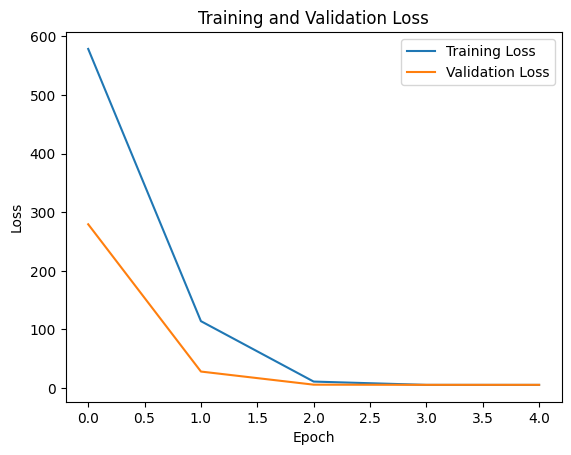

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [42]:
test_dataloader = torch.utils.data.DataLoader(Dataset(test, max_length=max_length), batch_size=32, drop_last=False)
p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu", criterion)
preds_pd = pd.DataFrame({"pred_lat": np.array(p)[:, 0], "pred_lon": np.array(p)[:, 1],
                         "gold_lat": np.array([i.numpy() for i in l])[:, 0], "gold_lon": np.array([i.numpy() for i in l])[:, 1]})
preds_pd.to_csv("proverb.predictions.csv", index=False)

In [43]:
from sklearn.metrics import *
print('MAE')
print(f"lat: {mean_absolute_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_absolute_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('MSE')
print(f"lat: {mean_squared_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_squared_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('R2')
print(f"lat: {r2_score(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {r2_score(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")

MAE
lat: 1.39
lon: 2.02
MSE
lat: 3.08
lon: 7.67
R2
lat: -3859960473.34
lon: -10552240456.87


In [40]:
torch.save(model.state_dict(), "bert-gr-r.pt")